# Parameters

In [1]:
# --------- PARAMETERS --------- #

RUN     = 118           # number of run

Nevents = 50            # number of events we are going to extract to plot

root = '/pnfs/pic.es/data/cta/LST/LST2/Data/ZFITS/'  # path to all folders with the .zfits files

# ------------------------------ #

# other parameters
dir_graphs = 'graphs/'
subrun     = 0          # number of subrun

Packages and imports

In [2]:
import numpy  as np
import matplotlib.pyplot as plt

from traitlets.config      import Config
from ctapipe.io            import EventSource

import auxiliar as aux
aux.parameters()

# creating the folder if dont exist
aux.create_folder(dir_graphs)  

# extracting the number of LST
LST_camera = aux.find_LST_num(root) 

# Data extraction

In [3]:
# findng to what date correspond the run
date, subruns = aux.search(root,RUN)

# to open a second run we need to use the first subrun of the run and
# extract the timestamp of the first event

# first subrun configuration
config = Config({'LSTEventSource': {'default_trigger_type': 'ucts','allowed_tels': [1],
                                    'min_flatfield_adc': 3000,'min_flatfield_pixel_fraction': 0.8,},})  

path = root+date+'/'
path = path + 'LST-'+str(LST_camera)+'.1.Run'+str(RUN).zfill(5)+'.'+str(0).zfill(4)+'.fits.fz'
source = EventSource( input_url = path ,config = config, max_events=1)

for i, ev in enumerate(source): 
    timestamp = int(ev.trigger.time.value)

# following subrun configuration
config = Config({'LSTEventSource': {'default_trigger_type': 'ucts','allowed_tels': [1],
                                    'min_flatfield_adc': 3000,'min_flatfield_pixel_fraction': 0.8,
                                    "EventTimeCalculator": {"dragon_module_id":133,
                                                            "dragon_reference_counter": 0,
                                                            "dragon_reference_time": timestamp,},},})

path = root + date+'/LST-'+str(LST_camera)+'.1.Run'+str(RUN).zfill(5)+'.'+str(subrun).zfill(4)+'.fits.fz' 


# once we have the timestamp extracted we can take the data we wanted
source = EventSource(input_url=path ,config=config, max_events=Nevents)

# extracting the waveforms
waveforms = [[] for i in range(Nevents)]

for i, ev in enumerate(source): 
    for px in range(1855):
        waveforms[i].append(ev.r0.tel[1].waveform[0][px][5:])


Cannot calculate a precise timestamp for obs_id=118, tel_id=1. UCTS unavailable.
Using event 1 as time reference for dragon. timestamp: 1651852322000000000 from svc.date counter: 4156230000
No drive report specified, pointing info will not be filled
No drive report specified, pointing info will not be filled


# Plot 1 event only

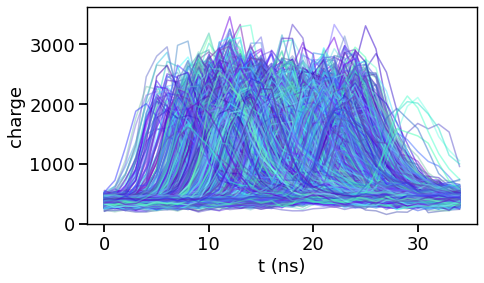

In [4]:
######################################

event_index = 12

######################################

aux.event_waveforms_plot(event_index, waveforms)

# for saving the plot uncomment and change the filename as you want
plt.savefig(dir_graphs + 'waveforms.pdf', format='pdf', bbox_inches='tight') 
plt.show()

# Plot multiple events

Event ID 1


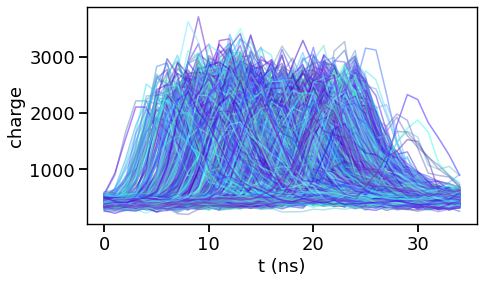

Event ID 2


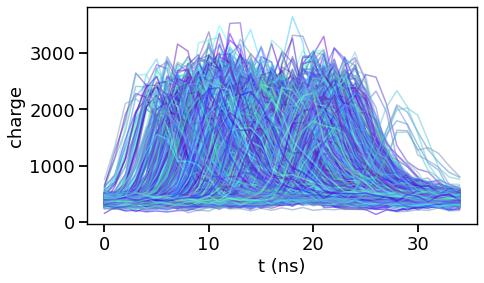

Event ID 3


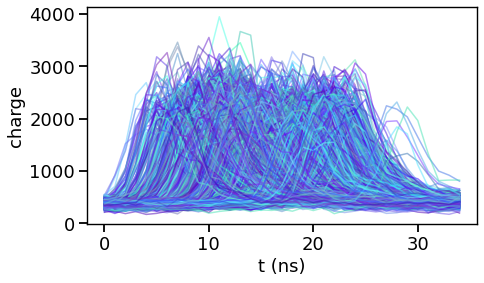

Event ID 4


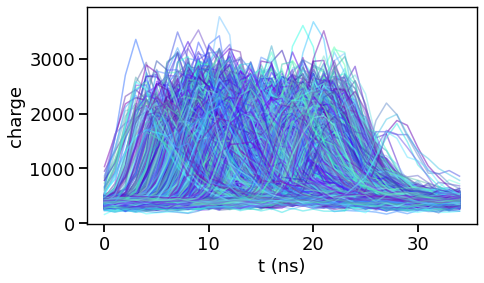

Event ID 5


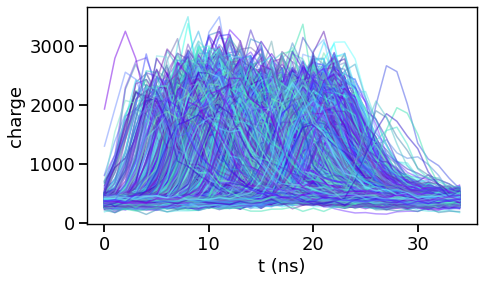

Event ID 6


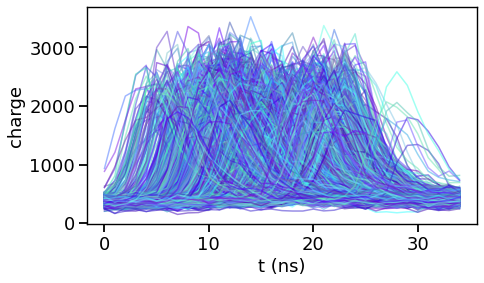

Event ID 7


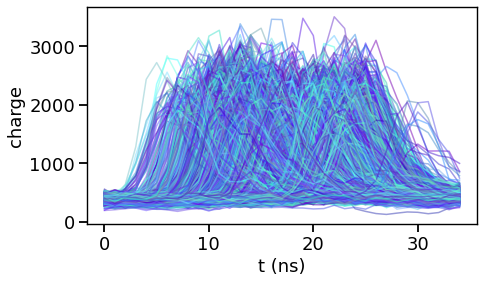

Event ID 8


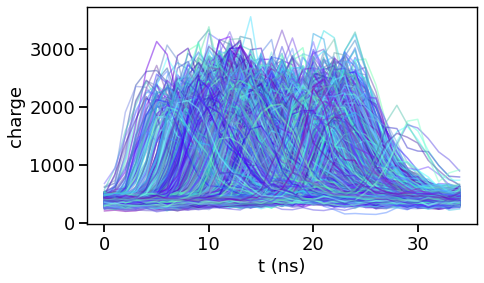

Event ID 9


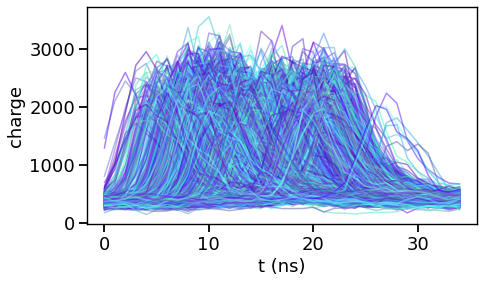

Event ID 10


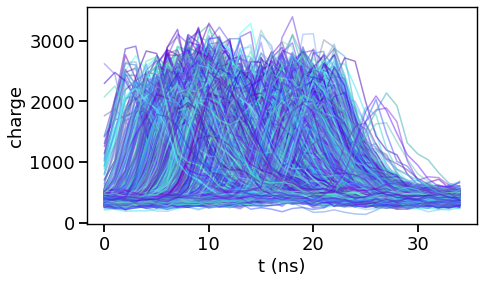

In [5]:
######################################

# create an array with all the event numbers we want to plot 
# (note: there are not eventID = 0, so start from 1)
event_indexes = np.array(range(10)) + 1

######################################

for ev in event_indexes:
    print('Event ID ' + str(ev))
    aux.event_waveforms_plot(ev, waveforms)
    plt.show()